In [1]:
import sys

print(sys.path)
sys.path.append("../src")

import RSC as RSC
import util as util

['/data2/wjlee/sw/conda/3/envs/RCT/lib/python39.zip', '/data2/wjlee/sw/conda/3/envs/RCT/lib/python3.9', '/data2/wjlee/sw/conda/3/envs/RCT/lib/python3.9/lib-dynload', '', '/home/wjlee/.local/lib/python3.9/site-packages', '/data2/wjlee/sw/conda/3/envs/RCT/lib/python3.9/site-packages']


### 1) Exact NUDGE: success or fail

In [4]:
import multiprocessing as mp
from typing import Any, Dict, Tuple

def _child_target(params: Dict[str, Any], out_q: mp.Queue) -> None:
    """
    - Success: {'success': 1, 'final_logics': <final_logics>}
    - Exception: {'success': 0, 'final_logics': 'timeout'} 
    """
    try:
        final_logics, max_recursion = RSC.find_terminal_logic(params)
        #print(1)
        out_q.put({"success": 1, "final_logics": str(final_logics[0])})
        #print(2)
    except Exception:
        out_q.put({"success": 0, "final_logics": "error"})
        #print(3)

def run_single_trial(params: Dict[str, Any], timeout_sec: int = 300) -> Tuple[int, Any]:
    ctx = mp.get_context()
    out_q: mp.Queue = ctx.Queue()
    p = ctx.Process(target=_child_target, args=(params, out_q))
    p.start()
    p.join(timeout=timeout_sec)

    # 1) still alive after timeout_sec
    if p.is_alive():
        p.terminate()
        p.join()
        return 0, 'timeout'

    # 2) process done, but no result → error
    try:
        msg = out_q.get_nowait()
    except Exception:
        return 0, 'error'

    success = int(msg.get("success", 0))
    fin = msg.get("final_logics", None)

    # 3) success == 1
    if success == 1:
        is_contradiction = (fin == '0')
        if is_contradiction:
            return 1, 'contradiction'
        return 1, fin

    # 4) success != 1 → error
    return 0, 'error'


In [2]:
converged_status_file = '../output/exact_NUDGE_results/biological_network_converged_status_type.tsv'

f = open(converged_status_file, 'w')
line = 'Network\tTarget\tStatus\tType\n'
f.write(line)
f.close()

In [3]:
# read network names and target names
import pandas as pd

df = pd.read_csv('../input/targets_all_8targets.csv')
network_target = []
for line in df.to_numpy():
    network_target.append((line[0], line[1]))

In [ ]:
TIMEOUT_SEC = 300
TOTAL_TRIALS = 1
N_CORES = 1
BATCH_SIZE = 1


for i in range(len(network_target)):
    print(i, network_target[i])

    network_file_name = '../input/networks/all/' + network_target[i][0]
    params = PARAMS.copy()
    params['target'] = network_target[i][1]
    params['network_file'] = network_file_name
    params['approx'] = False

    # result line
    converged_status_line = '{}\t{}\t'.format(network_target[i][0], network_target[i][1])

    success, fin = run_single_trial(params)

    print("success:", success)
    print("fin:", fin)

    if success:
        result_type = 'success'
    else:
        result_type = fin

    converged_status_line += '{}\t{}\n'.format(success, result_type)

    f = open(converged_status_file, 'a')
    f.write(converged_status_line)
    f.close()


### 2) Network feature

In [11]:
import numpy as np

def read_nodes_logics_primes(file_name):
    f = open(file_name, 'r')
    lines = f.readlines()
    f.close()

    bnet = '\n'
    nodes = []
    logics = {}
    for line in lines:
        line = line.replace('\n', '').replace('\t', '')
        nodes.append(line.split(',')[0])
        logics[line.split(',')[0]] = line.split(',')[1].replace('!', '! ')
        bnet = bnet + line.replace('!', '! ') + '\n'

    #print(bnet)
    #primes = bnet2primes(bnet)
    #primes = dict([(n, [np.array(primes[n][0]), np.array(primes[n][1])]) for n in primes])

    return nodes, logics


import networkx as nx


def get_BN_structure(logic_dict):
    GRN_structure = nx.DiGraph()
    for node in logic_dict:
        splited = logic_dict[node].replace('  ', ' ').replace('(', '( ').replace(')', ' )').split(' ')
        for i in range(len(splited)):
            if splited[i] not in ['', '(', ')', '&', '|', '~', '!']:
                if i == 0 or '!' == splited[i - 1]:
                    GRN_structure.add_edge(splited[i], node, weight=-1)
                else:
                    GRN_structure.add_edge(splited[i], node, weight=1)
    return GRN_structure


def get_link_sign(GRN_structure):
    sign_dict = {}
    pes, nes = [], []
    for u, v, d in GRN_structure.edges(data=True):
        if d['weight'] == 1:
            pes.append((u, v))
            sign_dict[(u, v)] = 1
        else:
            nes.append((u, v))
            sign_dict[(u, v)] = 0
    return sign_dict, pes, nes

from matplotlib import pyplot as plt

def plot_network(GRN_structure, nes):
    GRN_structure = GRN_structure.copy()

    for e in nes:
        GRN_structure.remove_edge(e[0], e[1])
        GRN_structure.add_edge(e[0], e[1], weight=1)

    fig, ax = plt.subplots(figsize=(8, 8))
    pos = nx.kamada_kawai_layout(GRN_structure)

    nx.draw_networkx(GRN_structure, pos=pos, node_color='grey')
    nx.draw_networkx_edges(GRN_structure, pos=pos, edgelist=nes, edge_color='red', ax=ax)

    plt.show()

In [12]:
# read network names and target names
import pandas as pd

df = pd.read_csv('../input/targets_all_8targets.csv')
network_names = []
for line in df.to_numpy():
    network_names.append(line[0])

df['Network'] = network_names

In [13]:
network_features_df = []

for network_name in np.unique(network_names):
    network_file_name = '../input/networks/all/' + network_name

    nodes, logics = read_nodes_logics_primes(network_file_name)
    n_nodes = len(nodes)

    GRN_structure = get_BN_structure(logics)
    n_edges = len(GRN_structure.edges())

    sign_dict, pes, nes = get_link_sign(GRN_structure)
    
    degrees = list(dict(GRN_structure.degree()).values())
    max_degree = max(degrees)
    
    sccs = list(nx.strongly_connected_components(GRN_structure))
    len_sccs = [len(scc) for scc in sccs]
    lscc_size = max(len_sccs)

    network_features_df.append((n_nodes, n_edges, max_degree, lscc_size))



network_features_df = pd.DataFrame(network_features_df,
                                   columns=['n_nodes', 'n_edges', 'max_degree', 'lscc_size'])
network_features_df.index = np.unique(network_names)


In [14]:
# feedbacks
import time

max_num_feed = 1000000

feedback_num_dict = {}

for network_name in np.unique(network_names):
    network_file_name = '../input/networks/all/' + network_name

    nodes, logics = read_nodes_logics_primes(network_file_name)
    GRN_structure = get_BN_structure(logics)
    sign_dict, pes, nes = get_link_sign(GRN_structure)

    feed_num = 0
    start = time.time()
    for f in nx.simple_cycles(GRN_structure):
        feed_num += 1
        if feed_num >= max_num_feed:
            break
    end = time.time()

    feedback_num_dict[network_name] = feed_num

df_features = network_features_df.copy()
df_features['feedback_num'] = list(feedback_num_dict.values())


In [15]:
max_btw_dict, max_close_dict = {}, {}
for network_name in np.unique(network_names):
    network_file_name = '../input/networks/all/' + network_name

    nodes, logics = read_nodes_logics_primes(network_file_name)
    GRN_structure = get_BN_structure(logics)
    sign_dict, pes, nes = get_link_sign(GRN_structure)

    max_btw_dict[network_name] = max(nx.betweenness_centrality(GRN_structure).values())
    max_close_dict[network_name] = max(nx.closeness_centrality(GRN_structure).values())


df_features['max_btw']= list(max_btw_dict.values())
df_features['max_close']= list(max_close_dict.values())


In [16]:
df_features.to_csv('../output/network_feature_results/network_rsc_features.csv')


### 3) Area Under Curve

In [21]:
def plot_histograms(df, grid=(3,6)):
    fig, axes = plt.subplots(grid[0], grid[1], figsize=(15, 8))
    axes = axes.flatten()
    cols = df.columns

    for i, col in enumerate(cols):
        axes[i].hist(df[col].dropna(), bins=30, color='steelblue', alpha=0.7)
        axes[i].set_title(col, fontsize=20)
        axes[i].set_ylabel("Count")

    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [18]:
import pandas as pd

df_features = pd.read_csv('../output/network_feature_results/network_rsc_features.csv', index_col=0)

In [20]:
df_features.columns

Index(['n_nodes', 'n_edges', 'max_degree', 'lscc_size', 'feedback_num',
       'max_btw', 'max_close'],
      dtype='object')

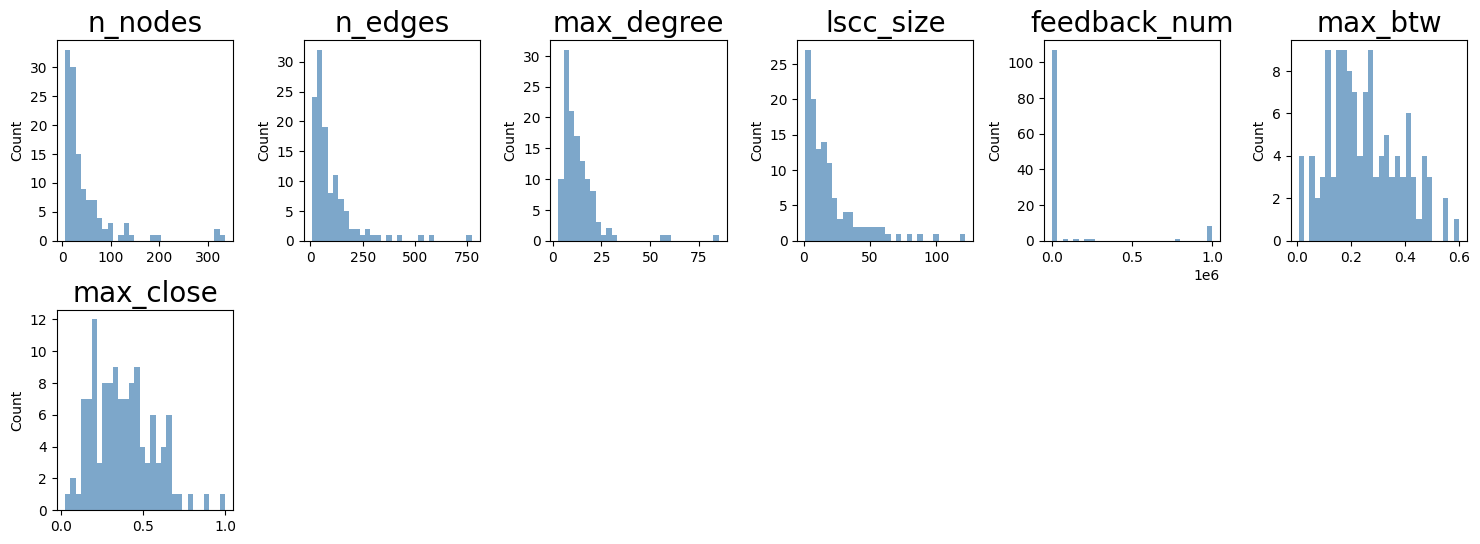

In [22]:
plot_histograms(df_features)


In [28]:
import numpy as np
# exact

converged_status_file = '../output/exact_NUDGE_results/biological_network_converged_status_type.tsv'

converged_status_df = pd.read_csv(converged_status_file, sep='\t')


In [29]:
network_names = df_features.index


In [30]:
converged_status_df

,Network,Target,Status,Type
0,11082279.bnet,Cyclin_E,1,success
1,11082279.bnet,!Cyclin_E,1,success
2,11082279.bnet,p27,1,success
3,11082279.bnet,!p27,1,success
4,11082279.bnet,S_phase_genes,1,success
...,...,...,...,...
1885,Yeast Apoptosis_23233838.bnet,!YCA1,1,success
1886,Yeast Apoptosis_23233838.bnet,KAP123,1,success
1887,Yeast Apoptosis_23233838.bnet,!KAP123,1,success
1888,Yeast Apoptosis_23233838.bnet,MEC1,1,success


In [31]:
converged_status_merged_df = []
for network_name in np.unique(network_names):
    success_rate = 0
    for line in converged_status_df.loc[converged_status_df['Network']==network_name].to_numpy():
        success_rate += int(line[2])
    success_rate = success_rate/np.count_nonzero(converged_status_df['Network'] == network_name)
    converged_status_merged_df.append([success_rate])

converged_status_merged_df = pd.DataFrame(converged_status_merged_df, index=np.unique(network_names), columns=['success_rate'])


In [32]:
converged_status_merged_df

,success_rate
11082279.bnet,1.000
1753781.bnet,1.000
18194572.bnet,1.000
19524598.bnet,1.000
19622164_TGF_beta1.bnet,1.000
...,...
Tumour Cell Invasion and Migration_26528548.bnet,0.125
Wg Pathway of Drosophila Signalling Pathways_23868318.bnet,1.000
Yeast Apoptosis_23233838.bnet,1.000
fMRI - Regulation of the Lac Operon_25790483.bnet,1.000


In [33]:
converged_status_merged_df['success'] = (converged_status_merged_df['success_rate']==1.0).astype(int)
converged_status_merged_df['fail'] = (converged_status_merged_df['success_rate']<1.0).astype(int)


In [34]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_grid(X: pd.DataFrame, y, nrows=6, ncols=5):
    cols = X.columns.tolist()
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2.6))

    if nrows==1 and ncols==1:
        axes = np.array([axes], dtype=object)
    else:
        axes = axes.ravel()
    aucs = {}

    y_series = pd.Series(y, index=X.index)

    for i, col in enumerate(cols):
        ax = axes[i]
        x = X[col]
        mask = x.notna() & y_series.notna()
        y_sub = y_series[mask].values
        s_sub = x[mask].values

        if len(np.unique(y_sub)) < 2:
            ax.text(0.5, 0.5, "one class only", ha="center", va="center")
            ax.set_axis_off()
            aucs[col] = np.nan
            continue

        fpr, tpr, _ = roc_curve(y_sub, s_sub)
        auc = roc_auc_score(y_sub, s_sub)
        aucs[col] = auc

        ax.plot(fpr, tpr, lw=1)
        ax.plot([0,1],[0,1], ls="--", lw=0.8)
        ax.set_xlim(0,1); ax.set_ylim(0,1)
        ax.set_title(f"{col}\nAUC={auc:.3f}", fontsize=9)

        if i % ncols == 0:
            ax.set_ylabel("TPR")
        if i // ncols == nrows - 1:
            ax.set_xlabel("FPR")

    for j in range(len(cols), nrows*ncols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
    return pd.Series(aucs, name="AUC").sort_values(ascending=False)

import math

def plot_topN_roc_with_j(X: pd.DataFrame, y_prob, top_n=10, ncols=5, auto_flip=False):
    
    y_bin = (pd.Series(y_prob, index=X.index) >= 0.5).astype(int).values

    aucs = {}
    flipped = {}
    for col in X.columns:
        s = X[col].values
        mask = np.isfinite(s) & np.isfinite(y_bin)
        if mask.sum() < 2 or len(np.unique(y_bin[mask])) < 2 or np.all(s[mask] == s[mask][0]):
            aucs[col] = np.nan
            continue
        auc_score = roc_auc_score(y_bin[mask], s[mask])
        if auto_flip:
            if auc_score < 0.5:
                aucs[col] = 1-auc_score
                flipped[col] = 1
                continue
            flipped[col] = 0
        aucs[col] = auc_score

    rank = pd.Series(aucs, name="AUC").dropna().sort_values(ascending=False)
    feats = rank.index[:top_n].tolist()

    nrows = math.ceil(len(feats) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3.0, nrows*2.6))
    axes = np.array(axes).ravel()

    summary = []

    for i, col in enumerate(feats):
        ax = axes[i]
        s = X[col].values

        if auto_flip and flipped[col]:
            flip_y_bin = 1-y_bin
            mask = np.isfinite(s) & np.isfinite(flip_y_bin)
            yb, sb = flip_y_bin[mask], s[mask]
        else:
            mask = np.isfinite(s) & np.isfinite(y_bin)
            yb, sb = y_bin[mask], s[mask]

        fpr, tpr, thr = roc_curve(yb, sb)
        valid = np.isfinite(thr)
        fpr_v, tpr_v, thr_v = fpr[valid], tpr[valid], thr[valid]

        j_vals = tpr_v - fpr_v
        j_idx = int(np.argmax(j_vals))
        j_thr = float(thr_v[j_idx]); j_tpr = float(tpr_v[j_idx]); j_fpr = float(fpr_v[j_idx])

        auc = roc_auc_score(yb, sb)

        if auto_flip and flipped[col]:
            ax.plot(fpr, tpr, lw=1.0, color='red')
        else:
            ax.plot(fpr, tpr, lw=1.0)
        ax.plot([0,1],[0,1], ls="--", lw=0.8)
        ax.scatter([j_fpr], [j_tpr], s=25)  
        ax.set_xlim(0,1); ax.set_ylim(0,1)
        ax.set_title(f"{col}\nAUC={auc:.3f} | J-thr={j_thr:.3g}", fontsize=16)

        if i % ncols == 0:
            ax.set_ylabel("TPR")
        if i // ncols == nrows - 1:
            ax.set_xlabel("FPR")

        summary.append({
            "feature": col,
            "AUC": auc,
            "youden_thr": j_thr,
            "TPR_at_thr": j_tpr,
            "FPR_at_thr": j_fpr
        })

    for j in range(len(feats), nrows*ncols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(summary).sort_values("AUC", ascending=False).reset_index(drop=True)


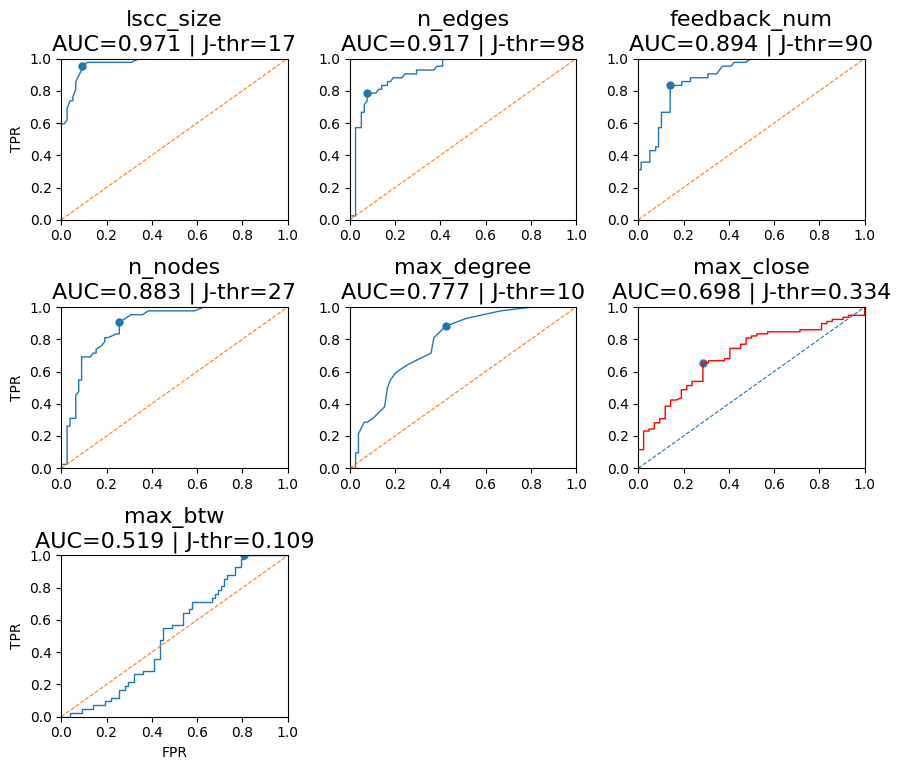

        feature       AUC  youden_thr  TPR_at_thr  FPR_at_thr
0     lscc_size  0.971306   17.000000    0.952381    0.089744
1       n_edges  0.916819   98.000000    0.785714    0.076923
2  feedback_num  0.893926   90.000000    0.833333    0.141026
3       n_nodes  0.882631   27.000000    0.904762    0.256410
4    max_degree  0.777473   10.000000    0.880952    0.423077
5     max_close  0.698260    0.334023    0.653846    0.285714
6       max_btw  0.519231    0.109190    1.000000    0.807692


In [36]:
summary_df = plot_topN_roc_with_j(df_features, converged_status_merged_df['fail'], top_n=7, ncols=3, auto_flip=True)
print(summary_df)

In [39]:
temp1 = pd.DataFrame([converged_status_merged_df.index, converged_status_merged_df['success']], index=['network_id', 'status']).transpose()
temp2 = pd.DataFrame([df_features.index, df_features['lscc_size']], index=['network_id', 'lscc_size']).transpose()


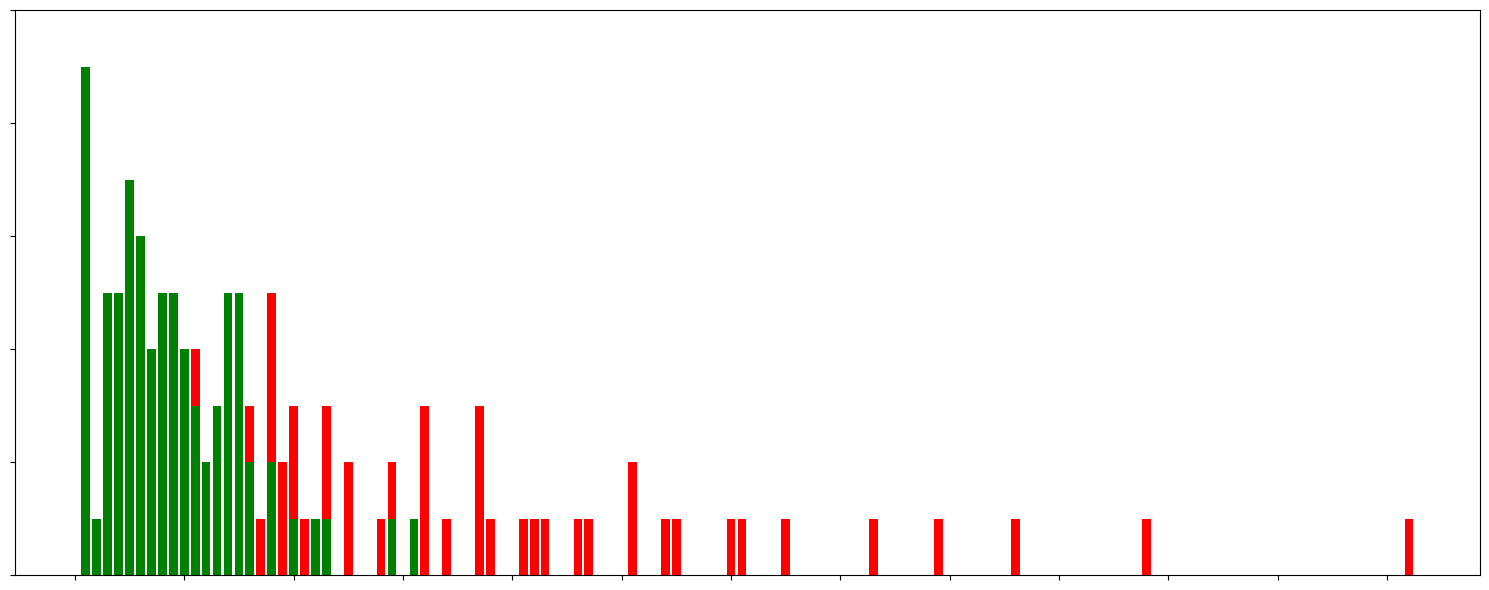

In [40]:
from matplotlib import pyplot as plt

df = pd.merge(temp1, temp2, on='network_id')
agg = df.groupby(['lscc_size', 'status']).size().unstack(fill_value=0)
ratio = agg.div(agg.sum(axis=1), axis=0)

plt.figure(figsize=(15, 6))

plt.bar(agg.index, agg[1], color='green', label='Success')
plt.bar(agg.index, agg[0], bottom=agg[1], color='red', label='Fail')

#plt.xlabel('LSCC size')
#plt.ylabel('Count')
#plt.title('Success/Fail Counts by LSCC Size')
#plt.legend()
plt.ylim([0, 10])
plt.xticks([i*10 for i in range(13)], ['' for i in range(13)])
plt.yticks([i*2 for i in range(6)], ['' for i in range(6)])
plt.tight_layout()
plt.show()
#plt.savefig('results/plot/success_fail_counts.png', dpi=300, bbox_inches='tight')
